In [1]:
from my_commonfunctions import *
from matplotlib import *

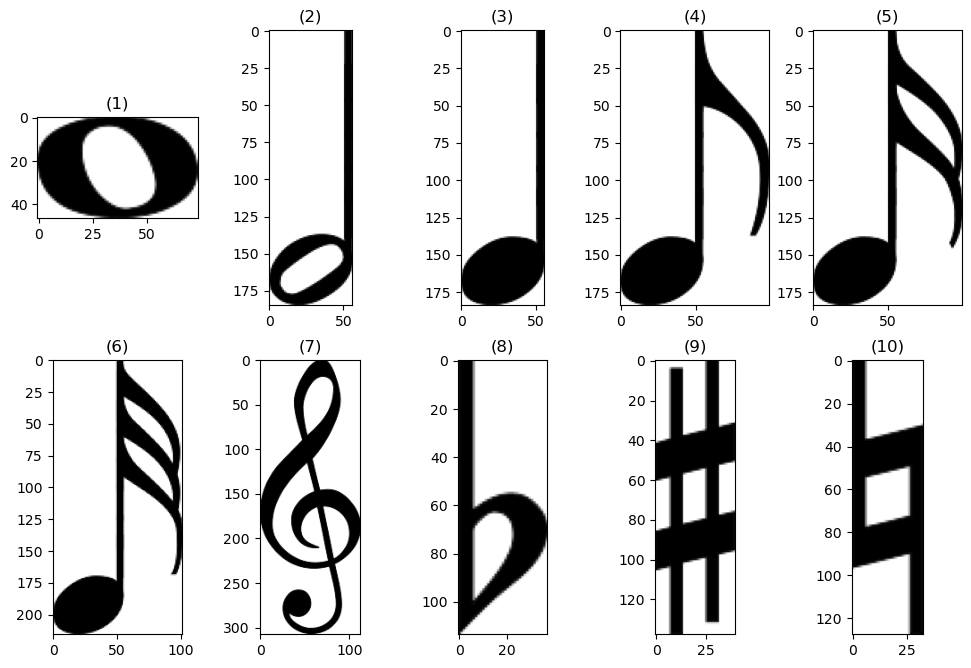

In [2]:
whole_note_img = my_imread_gray('Symbols/whole_note.png')
half_note_img = my_imread_gray('Symbols/half_note.png')
quarter_note_img = my_imread_gray('Symbols/quarter_note.png')
eighth_note_img = my_imread_gray('Symbols/eighth_note.png')
sixteenth_note_img = my_imread_gray('Symbols/sixtheenth_note.png')
thirty_second_img = my_imread_gray('Symbols/thirty_second_note.png')

treple_clef_img = my_imread_gray('Symbols/treple_clef.png')

flat_accidental_img = my_imread_gray('Symbols/flat_accidental.png')
sharp_accidental_img = my_imread_gray('Symbols/sharp_accidental.png')
natural_accidental_img = my_imread_gray('Symbols/natural_accidental.png')

all_symbols = [whole_note_img, half_note_img, quarter_note_img, eighth_note_img, sixteenth_note_img, thirty_second_img, treple_clef_img, flat_accidental_img, sharp_accidental_img, natural_accidental_img]

my_show_images(all_symbols, dpi=100, row_max=5)

In [3]:
sift = cv2.xfeatures2d.SIFT_create()
key_points = []
descriptors = []
for s in all_symbols:
    kp, des = sift.detectAndCompute(s, None)
    key_points.append(kp)
    descriptors.append(des)

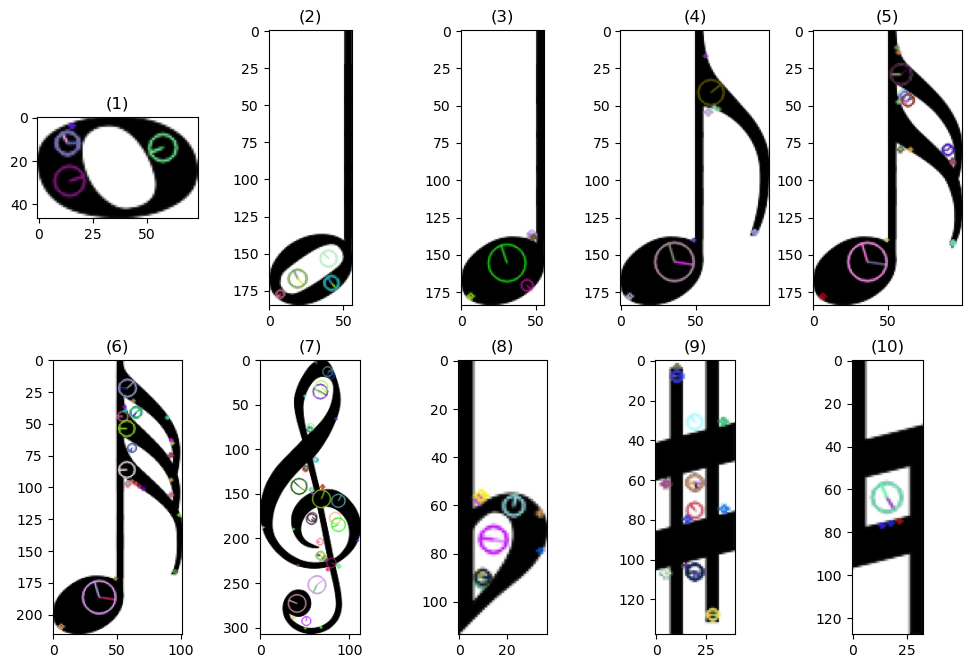

In [4]:
key_points_drawn = []
for s, k, d in zip(all_symbols, key_points, key_points):
    kp_drawn = np.copy(s)
    kp_drawn = cv2.drawKeypoints(s, k, kp_drawn, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    key_points_drawn.append(kp_drawn)

my_show_images(key_points_drawn, dpi=100, row_max=5)

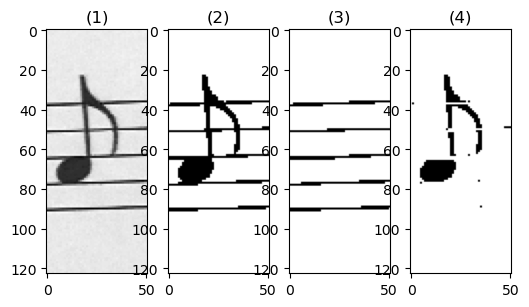

In [5]:
shubra1 = my_imread_gray('shubra1/out1.png')

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(shubra1, (5, 5), 0)
ret, shubra1_thresh = cv2.threshold(shubra1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

k = np.ones((1, 20))

staff_lines = (cv2.dilate(cv2.erode(~shubra1_thresh, k), k) > 128)
# shubra1_thresh = shubra1_thresh > 128

staff_lines_removed = ((~((~shubra1_thresh) & (~(staff_lines)) > 0.5)) * 255).astype(np.uint8)
my_show_images([shubra1, shubra1_thresh, ~staff_lines, staff_lines_removed], dpi=100, row_max=4)

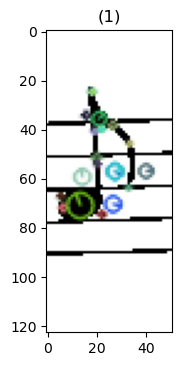

In [6]:
shubra1_kp, shubra1_des = sift.detectAndCompute(shubra1_thresh, None)
shubra1_kp_drawn = np.copy(shubra1_thresh)
shubra1_kp_drawn = cv2.drawKeypoints(shubra1_thresh, shubra1_kp, kp_drawn, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

my_show_images([shubra1_kp_drawn], dpi=100)

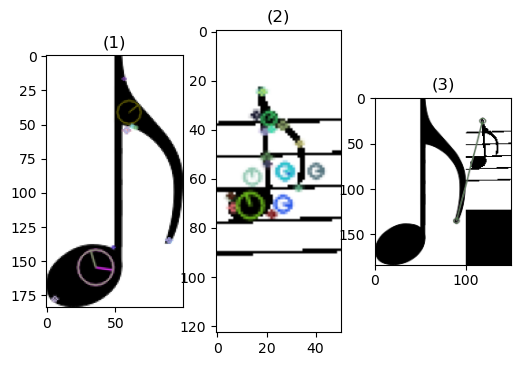

In [7]:
i = 3

# create BFMatcher object
bf = cv2.BFMatcher()
# Match descriptors.
matches = bf.knnMatch(descriptors[i], shubra1_des, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
matches_drawn = cv2.drawMatchesKnn(all_symbols[i], key_points[i], shubra1_thresh, shubra1_kp, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

my_show_images([key_points_drawn[i], shubra1_kp_drawn, matches_drawn], dpi=100, row_max=3)

# Removing staff lines

In [8]:
def draw_hough_lines(lines, shape, line_thickness):
    lines_img = np.zeros(shape)
    for l in lines:
        x1 = l[0][0]
        y1 = l[0][1]
        x2 = l[1][0]
        y2 = l[1][1]
        #print(l)
        #print(x1, y1, x2, y2)
        cv2.line(lines_img, (x1,y1), (x2,y2), (255,255,255), line_thickness)

    return lines_img

11 1
(123, 83)


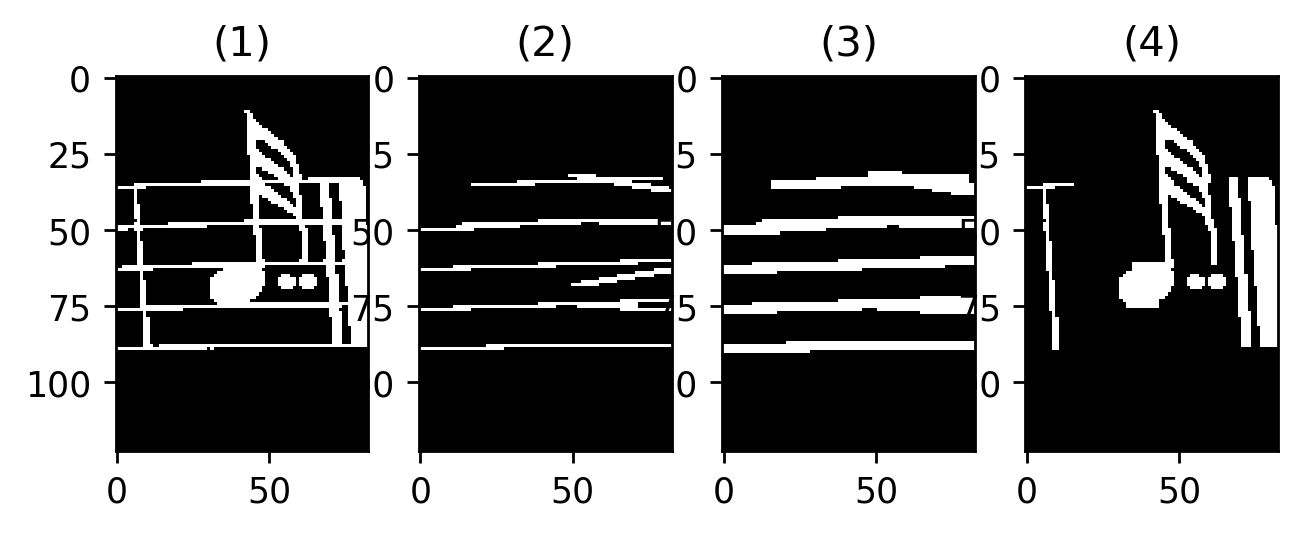

In [13]:
DEG_TO_RAD = np.pi/180

shubra1 = my_imread_gray('shubra1/out0.png')
width = shubra1.shape[1]

distance_between_staves, staff_thickness = get_distance_between_staves_and_staff_thickness(shubra1_thresh)
print(distance_between_staves, staff_thickness)

# Otsu's thresholding after Gaussian filtering
ret, shubra1_thresh = cv2.threshold(shubra1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


lines = probabilistic_hough_line(~shubra1_thresh, threshold=10, line_length=int(width/3), line_gap=3, theta=np.arange(80*DEG_TO_RAD, 100*DEG_TO_RAD, 1*DEG_TO_RAD))


lines_img_before_filteration = draw_hough_lines(lines, shubra1_thresh.shape, 1)
print(lines_img_before_filteration.shape)
lines_img_before_filteration = cv2.dilate(lines_img_before_filteration, np.ones((1, 7)))
lines_img = np.copy(lines_img_before_filteration)
image, contours, hierarchy = cv2.findContours(lines_img_before_filteration.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w < width*0.5:
        #print(lines_img[y:y+h+1, x:x+w+1])
        lines_img[y:y+h, x:x+w] = 0

lines_img = cv2.dilate(lines_img, np.ones((3, 3)))
lines_img_flattened = (lines_img > 128).T.flatten()




shubra1_thresh_flattened = (~shubra1_thresh).T.flatten()
#print(shubra1_thresh_flattened)
image, contours, hierarchy = cv2.findContours((shubra1_thresh_flattened).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print(contours)

for c in contours:
    if c.shape == (2, 1, 2):
        p1 = c[1][0][1]
        p0 = c[0][0][1]
        if p1 - p0 <= staff_thickness*1.55:
            # print(c)
            staff_pixel_percentage = lines_img_flattened[p0:p1+1].sum() / len(lines_img_flattened[p0:p1+1])
            if staff_pixel_percentage > 0.35:
                shubra1_thresh_flattened[p0:p1+1] = 0
    elif c.shape == (1, 1, 2):
        p0 = c[0][0][1]
        staff_pixel_percentage = lines_img_flattened[p0:p0+1].sum() / len(lines_img_flattened[p0:p0+1])
        if staff_pixel_percentage > 0.35:
            shubra1_thresh_flattened[p0:p0+1] = 0

'''staff_lines_removed_flattened = cv2.drawContours(gray2rgb((shubra1_thresh_flattened).astype(np.uint8)), contours_filtered, -1, (0,0,0), 3)

print(staff_lines_removed_flattened.T[0].shape)

staff_lines_removed = staff_lines_removed_flattened.T[0].reshape(shubra1_thresh.shape)'''
staff_lines_removed = shubra1_thresh_flattened.reshape(shubra1_thresh.T.shape).T

#print(~shubra1_thresh)
#cv2.imwrite('lines_img.png', (lines_img*255).astype(np.uint8))
#cv2.imwrite('shubra1_thresh.png', (((~shubra1_thresh) > 128)*255).astype(np.uint8))


my_show_images([~shubra1_thresh, lines_img_before_filteration, lines_img, staff_lines_removed], dpi=250, row_max=4)

In [259]:
DEG_TO_RAD = np.pi/180.0


lines = probabilistic_hough_line(~shubra1_thresh, threshold=10, line_length=100, line_gap=3, theta=np.arange(80*DEG_TO_RAD, 100*DEG_TO_RAD, 1*DEG_TO_RAD))

lines_img = draw_hough_lines(lines, shubra1_thresh.shape)


# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(~shubra1_thresh, cmap=cm.gray)

ax[1].imshow(~shubra1_thresh * 0)
for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, shubra1_thresh.shape[1]))
ax[1].set_ylim((shubra1_thresh.shape[0], 0))

ax[2].imshow(lines_img, cmap=cm.gray)

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

TypeError: draw_hough_lines() missing 1 required positional argument: 'line_thickness'

In [79]:
print(lines_img.max())

255.0


In [85]:
?cv2.imwrite

Docstring:
imwrite(filename, img[, params]) -> retval
.   @brief Saves an image to a specified file.
.   
.   The function imwrite saves the image to the specified file. The image format is chosen based on the
.   filename extension (see cv::imread for the list of extensions). Only 8-bit (or 16-bit unsigned (CV_16U)
.   in case of PNG, JPEG 2000, and TIFF) single-channel or 3-channel (with 'BGR' channel order) images
.   can be saved using this function. If the format, depth or channel order is different, use
.   Mat::convertTo , and cv::cvtColor to convert it before saving. Or, use the universal FileStorage I/O
.   functions to save the image to XML or YAML format.
.   
.   It is possible to store PNG images with an alpha channel using this function. To do this, create
.   8-bit (or 16-bit) 4-channel image BGRA, where the alpha channel goes last. Fully transparent pixels
.   should have alpha set to 0, fully opaque pixels should have alpha set to 255/65535.
.   
.   The sample below s